# Build Heston Calibration Inputs

This notebook merges all WRDS data into a unified dataset for Heston calibration:

**Inputs:**
- Volatility surface (IVs by delta)
- Underlying prices (spot)
- Zero curves (risk-free rates)
- Std option prices (forward prices → carry rate q)

**Outputs:**
- For each (date, T, delta, cp_flag): `S0, K, T, r, q, IV_market`
- Ready for QuantLib `HestonModelHelper` calibration

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import norm
import warnings

# -------------------
# CONFIG
# -------------------
TICKER = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2025-12-31"

RAW_DIR = Path("../../data/raw/ivydb")
PROCESSED_DIR = Path("../../data/processed")
HESTON_DIR = PROCESSED_DIR / "heston"
HESTON_DIR.mkdir(parents=True, exist_ok=True)

# File paths
VS_PATH = RAW_DIR / "vol_surface" / f"{TICKER}_vsurfd_{START_DATE}_{END_DATE}.csv.gz"
PX_PATH = RAW_DIR / "security_price" / f"{TICKER}_underlying_{START_DATE}_{END_DATE}.csv.gz"
ZC_PATH = RAW_DIR / "zero_curve" / f"zero_curve_{START_DATE}_{END_DATE}.csv.gz"
STDOP_PATH = RAW_DIR / "std_option_price" / f"{TICKER}_stdopd_{START_DATE}_{END_DATE}.csv.gz"

print("Input files:")
for p in [VS_PATH, PX_PATH, ZC_PATH, STDOP_PATH]:
    status = "✓" if p.exists() else "✗"
    print(f"  {status} {p.name}")

Input files:
  ✓ AAPL_vsurfd_2016-01-01_2025-12-31.csv.gz
  ✓ AAPL_underlying_2016-01-01_2025-12-31.csv.gz
  ✓ zero_curve_2016-01-01_2025-12-31.csv.gz
  ✓ AAPL_stdopd_2016-01-01_2025-12-31.csv.gz


## 1. Load Raw Data

In [3]:
# Load all datasets
vs = pd.read_csv(VS_PATH, parse_dates=["date"])
px = pd.read_csv(PX_PATH, parse_dates=["date"])
zc = pd.read_csv(ZC_PATH, parse_dates=["date"])
stdop = pd.read_csv(STDOP_PATH, parse_dates=["date"])

print(f"Vol Surface:  {vs.shape}")
print(f"Prices:       {px.shape}")
print(f"Zero Curve:   {zc.shape}")
print(f"Std Options:  {stdop.shape}")

Vol Surface:  (908446, 9)
Prices:       (2429, 11)
Zero Curve:   (77707, 3)
Std Options:  (53438, 8)


In [4]:
# Normalize delta if needed (ensure 0-1 scale)
if vs["delta"].abs().max() > 2:
    vs["delta"] = vs["delta"] / 100.0
    print("Normalized delta to 0-1 scale")

# Ensure cp_flag is uppercase
vs["cp_flag"] = vs["cp_flag"].str.upper()

# Convert days to years
vs["T"] = vs["days"] / 365.0

print(f"Delta range: [{vs['delta'].min():.4f}, {vs['delta'].max():.4f}]")
print(f"T range: [{vs['T'].min():.4f}, {vs['T'].max():.4f}] years")
print(f"cp_flag values: {vs['cp_flag'].unique().tolist()}")

Delta range: [-0.9000, 0.9000]
T range: [0.0274, 2.0000] years
cp_flag values: ['P', 'C']


## 2. Prepare Market Data Components

In [5]:
# Spot prices: one per date
spot_df = px[["date", "close"]].copy()
spot_df.columns = ["date", "S0"]
spot_df = spot_df.drop_duplicates(subset=["date"])
print(f"Spot prices: {len(spot_df)} dates")

# Zero rates: by (date, days)
rate_df = zc[["date", "days", "rate"]].copy()
rate_df.columns = ["date", "days", "r"]
rate_df = rate_df.drop_duplicates(subset=["date", "days"])
print(f"Zero rates: {len(rate_df)} (date, days) pairs")

# Forward prices: by (date, days) - take first per group (should be same for C/P)
fwd_df = stdop.groupby(["date", "days"])["forward_price"].first().reset_index()
fwd_df.columns = ["date", "days", "F"]
print(f"Forward prices: {len(fwd_df)} (date, days) pairs")

Spot prices: 2429 dates
Zero rates: 77707 (date, days) pairs
Forward prices: 26719 (date, days) pairs


In [6]:
# Merge forward prices with rates and spot to compute carry rate q
carry_df = fwd_df.merge(rate_df, on=["date", "days"], how="inner")
carry_df = carry_df.merge(spot_df, on="date", how="inner")

# Compute T and carry rate q(T)
carry_df["T"] = carry_df["days"] / 365.0

# q(T) = r(T) - (1/T) * ln(F/S0)
# Handle edge case where T is very small
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    carry_df["q"] = carry_df["r"] - (1 / carry_df["T"]) * np.log(carry_df["F"] / carry_df["S0"])

# Cap extreme q values (likely data issues)
q_cap = 0.20  # 20% max dividend yield
q_floor = -0.05  # Small negative allowed (repo rates)
outliers = (carry_df["q"] < q_floor) | (carry_df["q"] > q_cap)
print(f"Carry rate q: [{carry_df['q'].min():.4f}, {carry_df['q'].max():.4f}]")
print(f"Outliers (|q| extreme): {outliers.sum()} ({100*outliers.mean():.2f}%)")
carry_df["q"] = carry_df["q"].clip(q_floor, q_cap)

# Keep only needed columns
carry_df = carry_df[["date", "days", "S0", "r", "q", "T"]]
print(f"\nCarry data: {len(carry_df)} (date, days) pairs")
carry_df.head()

Carry rate q: [0.0686, 5.7410]
Outliers (|q| extreme): 10660 (98.88%)

Carry data: 10781 (date, days) pairs


,date,days,S0,r,q,T
0,2016-01-15,152.0,97.13,0.629217,0.2,0.416438
1,2016-01-20,91.0,96.79,0.586098,0.2,0.249315
2,2016-01-20,182.0,96.79,0.653650,0.2,0.498630
3,2016-02-17,91.0,98.12,0.589909,0.2,0.249315
4,2016-02-17,182.0,98.12,0.642889,0.2,0.498630


## 3. Delta → Strike Conversion

QuantLib calibration needs strikes, not deltas. We use the Black-Scholes delta formula inverted:

**For a call with delta Δ:**
$$K = S_0 \cdot e^{(q-r)T} \cdot e^{0.5\sigma^2 T - \sigma\sqrt{T} \cdot N^{-1}(\Delta e^{qT})}$$

**For a put with delta Δ (using |Δ|):**
$$K = S_0 \cdot e^{(q-r)T} \cdot e^{0.5\sigma^2 T + \sigma\sqrt{T} \cdot N^{-1}(|\Delta| e^{qT})}$$

We use the observed IV at that point as σ for the conversion.

In [7]:
def delta_to_strike(delta: float, S0: float, T: float, r: float, q: float, 
                    sigma: float, cp_flag: str) -> float:
    """
    Convert Black-Scholes delta to strike.
    
    Parameters:
        delta: Absolute delta (0 to 1)
        S0: Spot price
        T: Time to maturity in years
        r: Risk-free rate
        q: Dividend yield
        sigma: Implied volatility
        cp_flag: 'C' or 'P'
    
    Returns:
        Strike price K
    """
    if T <= 0 or sigma <= 0:
        return np.nan
    
    sqrt_T = np.sqrt(T)
    
    if cp_flag == "C":
        # Call delta: Δ = e^(-qT) * N(d1)
        # So N(d1) = Δ * e^(qT)
        # d1 = N^(-1)(Δ * e^(qT))
        adjusted_delta = delta * np.exp(q * T)
        if adjusted_delta <= 0 or adjusted_delta >= 1:
            return np.nan
        d1 = norm.ppf(adjusted_delta)
    else:  # Put
        # Put delta: Δ = -e^(-qT) * N(-d1) = e^(-qT) * (N(d1) - 1)
        # |Δ| = e^(-qT) * N(-d1)
        # N(-d1) = |Δ| * e^(qT)
        # d1 = -N^(-1)(|Δ| * e^(qT))
        adjusted_delta = delta * np.exp(q * T)  # delta is already absolute
        if adjusted_delta <= 0 or adjusted_delta >= 1:
            return np.nan
        d1 = -norm.ppf(adjusted_delta)
    
    # d1 = [ln(S/K) + (r - q + 0.5*σ²)*T] / (σ*√T)
    # Solve for K:
    # ln(S/K) = d1 * σ * √T - (r - q + 0.5*σ²)*T
    # K = S * exp(-[d1 * σ * √T - (r - q + 0.5*σ²)*T])
    K = S0 * np.exp(-(d1 * sigma * sqrt_T - (r - q + 0.5 * sigma**2) * T))
    
    return K

# Test
test_K = delta_to_strike(0.5, 100, 0.25, 0.05, 0.02, 0.20, "C")
print(f"Test: ATM call (delta=0.5) at S0=100, T=0.25, σ=20% → K={test_K:.2f}")
print(f"Expected: ~100 (ATM)")

Test: ATM call (delta=0.5) at S0=100, T=0.25, σ=20% → K=101.19
Expected: ~100 (ATM)


## 4. Build Complete Heston Input Dataset

In [8]:
# Start with vol surface and merge market data
heston_df = vs[["date", "days", "delta", "cp_flag", "impl_volatility"]].copy()
heston_df.columns = ["date", "days", "delta", "cp_flag", "iv_market"]

# Filter out missing/sentinel IVs
valid_iv = (heston_df["iv_market"] > 0) & (heston_df["iv_market"] < 2.0)  # IV < 200%
print(f"Vol surface rows: {len(heston_df):,}")
print(f"Valid IV rows:    {valid_iv.sum():,} ({100*valid_iv.mean():.1f}%)")
heston_df = heston_df[valid_iv].copy()

# Merge with carry data (S0, r, q)
heston_df = heston_df.merge(carry_df, on=["date", "days"], how="inner")
print(f"After merge with market data: {len(heston_df):,} rows")

Vol surface rows: 908,446
Valid IV rows:    908,446 (100.0%)
After merge with market data: 366,554 rows


In [9]:
# Convert delta to strike
print("Converting delta → strike (this may take a minute)...")

heston_df["K"] = heston_df.apply(
    lambda row: delta_to_strike(
        row["delta"], row["S0"], row["T"], row["r"], row["q"],
        row["iv_market"], row["cp_flag"]
    ),
    axis=1
)

# Check for failed conversions
failed = heston_df["K"].isna()
print(f"Strike conversions failed: {failed.sum():,} ({100*failed.mean():.2f}%)")
heston_df = heston_df[~failed].copy()

print(f"\nFinal dataset: {len(heston_df):,} rows")

Converting delta → strike (this may take a minute)...
Strike conversions failed: 194,707 (53.12%)

Final dataset: 171,847 rows


In [10]:
# Compute moneyness for reference
heston_df["moneyness"] = heston_df["K"] / heston_df["S0"]

print("Heston Input Dataset Summary:")
print(f"  Unique dates: {heston_df['date'].nunique():,}")
print(f"  Unique maturities (days): {sorted(heston_df['days'].unique())}")
print(f"  Unique deltas: {sorted(heston_df['delta'].unique())}")
print(f"  Moneyness range: [{heston_df['moneyness'].min():.3f}, {heston_df['moneyness'].max():.3f}]")
print(f"  IV range: [{heston_df['iv_market'].min():.4f}, {heston_df['iv_market'].max():.4f}]")

heston_df.head(10)

Heston Input Dataset Summary:
  Unique dates: 1,290
  Unique maturities (days): [np.int64(10), np.int64(30), np.int64(60), np.int64(91), np.int64(122), np.int64(152), np.int64(182), np.int64(273), np.int64(365), np.int64(547), np.int64(730)]
  Unique deltas: [np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5), np.float64(0.55), np.float64(0.6), np.float64(0.65), np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.85), np.float64(0.9)]
  Moneyness range: [0.371, 56987.347]
  IV range: [0.1359, 1.3215]


,date,days,delta,cp_flag,iv_market,S0,r,q,T,K,moneyness
17,2016-01-15,152,0.10,C,0.307552,97.13,0.629217,0.2,0.416438,151.306835,1.557777
18,2016-01-15,152,0.15,C,0.301833,97.13,0.629217,0.2,0.416438,143.316045,1.475508
19,2016-01-15,152,0.20,C,0.300407,97.13,0.629217,0.2,0.416438,137.690308,1.417588
20,2016-01-15,152,0.25,C,0.302165,97.13,0.629217,0.2,0.416438,133.258292,1.371958
21,2016-01-15,152,0.30,C,0.305443,97.13,0.629217,0.2,0.416438,129.422327,1.332465
22,2016-01-15,152,0.35,C,0.309623,97.13,0.629217,0.2,0.416438,125.911775,1.296322
23,2016-01-15,152,0.40,C,0.314535,97.13,0.629217,0.2,0.416438,122.577586,1.261995
24,2016-01-15,152,0.45,C,0.319371,97.13,0.629217,0.2,0.416438,119.303463,1.228286
25,2016-01-15,152,0.50,C,0.323324,97.13,0.629217,0.2,0.416438,116.024579,1.194529
26,2016-01-15,152,0.55,C,0.326828,97.13,0.629217,0.2,0.416438,112.709913,1.160403


## 5. Verify Structure per Date

In [11]:
# Check how many calibration points per date
points_per_date = heston_df.groupby("date").size()

print("Calibration points per date:")
print(points_per_date.describe())

# Expected: 11 maturities × 17 deltas × 2 cp = 374
# But with filtering, we may have less
expected = 11 * 17 * 2
print(f"\nExpected (full grid): {expected}")
print(f"Median actual: {points_per_date.median():.0f}")
print(f"Min: {points_per_date.min()}, Max: {points_per_date.max()}")

Calibration points per date:
count    1290.000000
mean      133.214729
std        68.046506
min        13.000000
25%        34.000000
50%       175.000000
75%       175.000000
max       175.000000
dtype: float64

Expected (full grid): 374
Median actual: 175
Min: 13, Max: 175


In [12]:
# Sample: look at one date's data
sample_date = heston_df["date"].iloc[len(heston_df)//2]
sample = heston_df[heston_df["date"] == sample_date].sort_values(["cp_flag", "days", "delta"])

print(f"Sample date: {sample_date}")
print(f"Spot: ${sample['S0'].iloc[0]:.2f}")
print(f"Points: {len(sample)}")
print(f"Maturities: {sorted(sample['days'].unique())}")
print(f"\nCall strikes (30-day):")
display(sample[(sample["cp_flag"]=="C") & (sample["days"]==30)][["delta", "K", "iv_market", "moneyness"]])

Sample date: 2023-09-15 00:00:00
Spot: $175.01
Points: 175
Maturities: [np.int64(10), np.int64(30), np.int64(60), np.int64(91), np.int64(122), np.int64(152), np.int64(182), np.int64(273), np.int64(365), np.int64(547), np.int64(730)]

Call strikes (30-day):


,delta,K,iv_market,moneyness
182971,0.10,284.339628,0.215415,1.624705
182972,0.15,278.801159,0.201092,1.593058
182973,0.20,275.212457,0.194575,1.572553
182974,0.25,272.586653,0.193618,1.557549
182975,0.30,270.347555,0.194563,1.544755
182976,0.35,268.269201,0.195519,1.532879
182977,0.40,266.309392,0.197307,1.521681
182978,0.45,264.420459,0.201571,1.510888
182979,0.50,262.487971,0.205228,1.499846
182980,0.55,260.506482,0.207139,1.488523


## 6. Save Heston Inputs

In [13]:
# Select and order columns for output
output_cols = ["date", "days", "T", "delta", "cp_flag", "S0", "K", "r", "q", "iv_market", "moneyness"]
heston_out = heston_df[output_cols].copy()

# Save as parquet for efficiency
output_path = HESTON_DIR / "inputs" / f"{TICKER}_heston_inputs.parquet"
output_path.parent.mkdir(parents=True, exist_ok=True)
heston_out.to_parquet(output_path, index=False)

print(f"Saved Heston inputs: {output_path}")
print(f"Shape: {heston_out.shape}")
print(f"Size: {output_path.stat().st_size / 1e6:.1f} MB")

Saved Heston inputs: ..\..\data\processed\heston\inputs\AAPL_heston_inputs.parquet
Shape: (171847, 11)
Size: 4.8 MB


In [14]:
# Also save a per-date summary for quick reference
date_summary = heston_df.groupby("date").agg({
    "S0": "first",
    "r": "mean",
    "q": "mean",
    "iv_market": ["mean", "std", "count"],
}).round(6)
date_summary.columns = ["S0", "r_mean", "q_mean", "iv_mean", "iv_std", "n_points"]
date_summary = date_summary.reset_index()

summary_path = HESTON_DIR / "inputs" / f"{TICKER}_heston_summary.csv"
date_summary.to_csv(summary_path, index=False)
print(f"Saved date summary: {summary_path}")
date_summary.head()

Saved date summary: ..\..\data\processed\heston\inputs\AAPL_heston_summary.csv


,date,S0,r_mean,q_mean,iv_mean,iv_std,n_points
0,2016-01-15,97.13,0.629217,0.2,0.328328,0.025474,17
1,2016-01-20,96.79,0.619874,0.2,0.353057,0.047742,34
2,2016-02-17,98.12,0.616399,0.2,0.304844,0.026914,34
3,2016-02-19,96.04,0.640536,0.2,0.302091,0.026404,17
4,2016-03-15,104.58,0.850532,0.2,0.267725,0.017421,15


## 7. Validation Plots

C:\Users\Admin\AppData\Local\Temp\ipykernel_30444\170901741.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


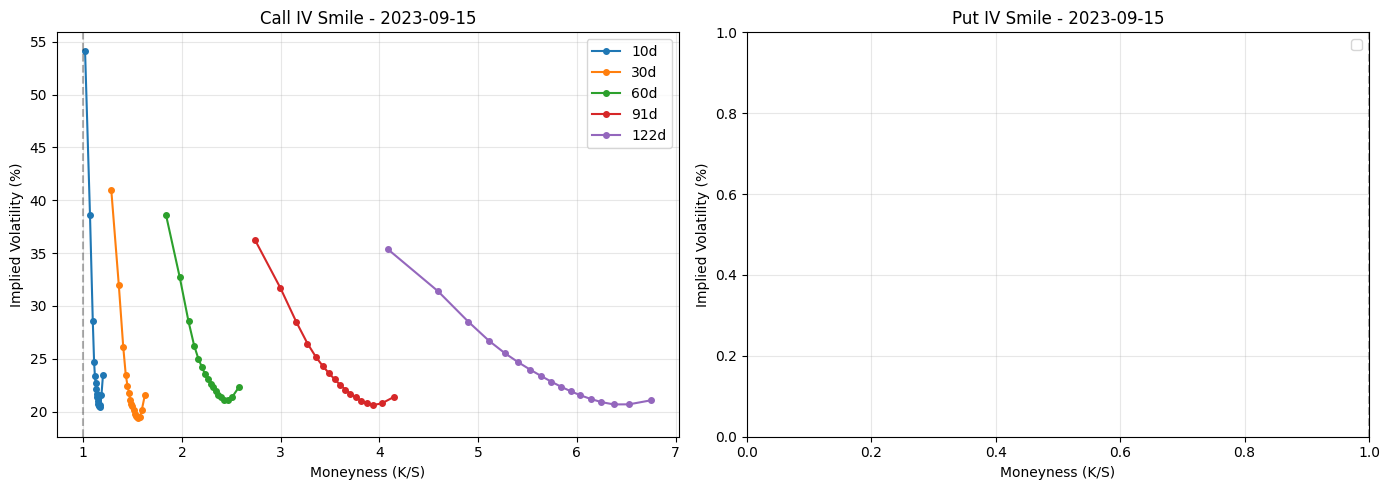

In [15]:
import matplotlib.pyplot as plt

# Plot IV smile for sample date
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, cp in zip(axes, ["C", "P"]):
    cp_data = sample[sample["cp_flag"] == cp]
    for days in sorted(cp_data["days"].unique())[:5]:  # First 5 maturities
        mat_data = cp_data[cp_data["days"] == days].sort_values("moneyness")
        ax.plot(mat_data["moneyness"], mat_data["iv_market"] * 100, 
                'o-', label=f"{days}d", markersize=4)
    
    ax.set_xlabel("Moneyness (K/S)")
    ax.set_ylabel("Implied Volatility (%)")
    ax.set_title(f"{'Call' if cp=='C' else 'Put'} IV Smile - {str(sample_date)[:10]}")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    ax.axvline(1.0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

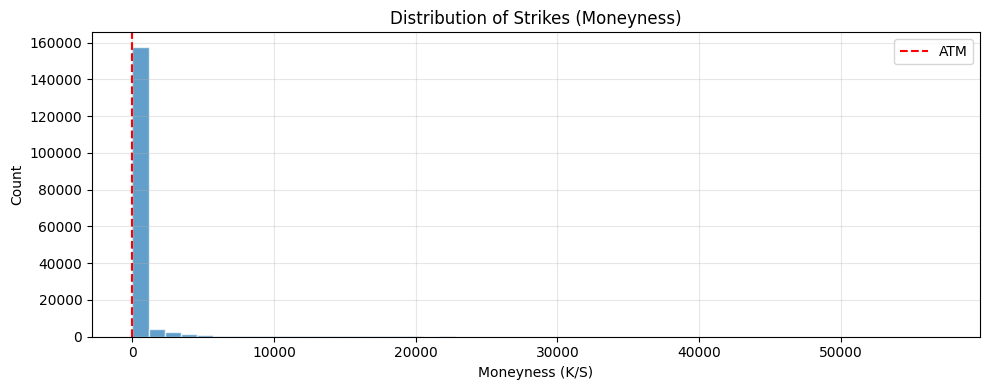

In [16]:
# Plot strike distribution
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(heston_df["moneyness"], bins=50, edgecolor='white', alpha=0.7)
ax.axvline(1.0, color='r', linestyle='--', label='ATM')
ax.set_xlabel("Moneyness (K/S)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Strikes (Moneyness)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
print("="*60)
print("PHASE 3 COMPLETE: Heston Inputs Built")
print("="*60)
print(f"\nOutput: {output_path}")
print(f"\nDataset contains {len(heston_out):,} calibration points:")
print(f"  • {heston_out['date'].nunique():,} unique dates")
print(f"  • {len(heston_out[heston_out['cp_flag']=='C']):,} calls")
print(f"  • {len(heston_out[heston_out['cp_flag']=='P']):,} puts")
print(f"\nEach row has: date, T, delta, cp_flag, S0, K, r, q, iv_market")
print(f"\nNext: Phase 5 - QuantLib Heston calibration")

PHASE 3 COMPLETE: Heston Inputs Built

Output: ..\..\data\processed\heston\inputs\AAPL_heston_inputs.parquet

Dataset contains 171,847 calibration points:
  • 1,290 unique dates
  • 171,847 calls
  • 0 puts

Each row has: date, T, delta, cp_flag, S0, K, r, q, iv_market

Next: Phase 5 - QuantLib Heston calibration
